In [1]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import CPS

In [3]:
opt = CPS.config()
args = opt.parse_args(['--seed', '2025'])
args.prep_scale = False
args.dataset_path = '/mnt/d/Dataset/SRT_Dataset/MOSTA'
args.max_neighbors=8
args.hvgs=2000
args.er_w=0.1
args.sigma=1
args.freq=32
CPS.set_random_seed(args.seed)
args.k_list = [0,1,2,3,5,8,13,21]
args

Namespace(batch_size=256, clusters=7, coord_dim=2, dataset_path='/mnt/d/Dataset/SRT_Dataset/MOSTA', decoder_latent=[256, 512, 1024], distill=1.0, dropout=0.2, embedd_dim=512, er_w=0.1, flow='source_to_target', freq=32, gpu=0, hvgs=2000, inr_latent=[256, 256, 256], k_list=[0, 1, 2, 3, 5, 8, 13, 21], latent_dim=64, lr=0.001, max_epoch=1000, max_neighbors=8, n_spot=0, num_heads=4, prep_scale=False, radius=150, seed=2025, self_loops=True, sigma=1, weight_decay=0.0001)

In [4]:
adata = sc.read_h5ad(args.dataset_path + '/E9.5_E1S1.MOSTA.h5ad')
adata

AnnData object with n_obs × n_vars = 5913 × 25568
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'annotation', 'Regulon - 2310011J03Rik', 'Regulon - 5730507C01Rik', 'Regulon - Alx1', 'Regulon - Alx3', 'Regulon - Alx4', 'Regulon - Ar', 'Regulon - Arid3a', 'Regulon - Arid3c', 'Regulon - Arnt2', 'Regulon - Arx', 'Regulon - Ascl1', 'Regulon - Atf1', 'Regulon - Atf4', 'Regulon - Atf5', 'Regulon - Atf6', 'Regulon - Atf7', 'Regulon - Bach1', 'Regulon - Bach2', 'Regulon - Barhl1', 'Regulon - Barx1', 'Regulon - Batf', 'Regulon - Bcl11a', 'Regulon - Bcl3', 'Regulon - Bcl6', 'Regulon - Bcl6b', 'Regulon - Bclaf1', 'Regulon - Bdp1', 'Regulon - Bhlha15', 'Regulon - Bhlhe22', 'Regulon - Bhlhe23', 'Regulon - Bhlhe41', 'Regulon - Bmyc', 'Regulon - Boll', 'Regulon - Bptf', 'Regulon - Brca1', 'Regulon - Brf1', 'Regulon - Brf2', 'Regulon - Bsx', 'Regulon - Cdx1', 'Regulon - Cdx2', 'Regulon - Cebpa', 'Regulon - Cebpz', 'Regulon - Chd1', 'Regulon - Clock', 'Re

In [5]:
adata.obs['annotation']

cell_name
147_104        Cavity
147_105        Cavity
147_106        Cavity
147_107        Cavity
147_108    Mesenchyme
              ...    
253_110        Cavity
253_111        Cavity
253_112        Cavity
253_113        Cavity
253_114        Cavity
Name: annotation, Length: 5913, dtype: category
Categories (12, object): ['AGM', 'Brain', 'Branchial arch', 'Cavity', ..., 'Mesenchyme', 'Neural crest', 'Notochord', 'Sclerotome']

In [6]:
adata.var_names_make_unique()
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=args.hvgs)
adata_hvg = adata[:, adata.var['highly_variable']].copy()
sc.pp.normalize_total(adata_hvg, target_sum=1e4)
sc.pp.log1p(adata_hvg)
sc.pp.scale(adata_hvg, zero_center=True)

counts_layer = adata_hvg.layers['counts']
adata_hvg.obsm['hvg_features'] = adata_hvg.X
adata_hvg.obsm['hvg_counts'] = counts_layer.toarray()

In [7]:
spatial_edge = CPS.SpatialGraphBuilder(args)
pyg_data = spatial_edge.build_single_graph(adata_hvg, method='knn')
print(pyg_data.num_nodes, pyg_data.num_genes, pyg_data.edge_index.shape)

5913 2000 torch.Size([2, 54079])


In [8]:
cps_model = CPS.CPSTrainer(args)
cps_model.fit(pyg_data)

  0%|          | 0/1000 [00:00<?, ?it/s]

0.10395123809576035 2.079233169555664

Epoch   0: Train[Total:1.9576, T:0.6677, S:0.5211, D:0.7688]
0.10395147651433945 2.079235553741455
0.10395274311304092 2.0792481899261475
0.10395276546478271 2.0792484283447266
0.10395348072052002 2.0792555809020996
0.1039532944560051 2.079253673553467
0.1039535328745842 2.079256057739258
0.10395252704620361 2.0792460441589355
0.10395288467407227 2.079249620437622
0.10395260155200958 2.079246759414673
0.10395212471485138 2.079241991043091

Epoch  10: Train[Total:0.9480, T:0.3651, S:0.2611, D:0.3218]
0.10395167022943497 2.079237461090088
0.10395205020904541 2.0792412757873535
0.10395190864801407 2.079239845275879
0.10395243018865585 2.079245090484619
0.10395193099975586 2.079240083694458
0.10395290702581406 2.079249858856201
0.10395205020904541 2.0792412757873535
0.10395252704620361 2.0792460441589355
0.10395293682813644 2.0792500972747803
0.10395243018865585 2.079245090484619

Epoch  20: Train[Total:0.8813, T:0.3560, S:0.2524, D:0.2729]
0.10395216

0.0 0.871198296546936


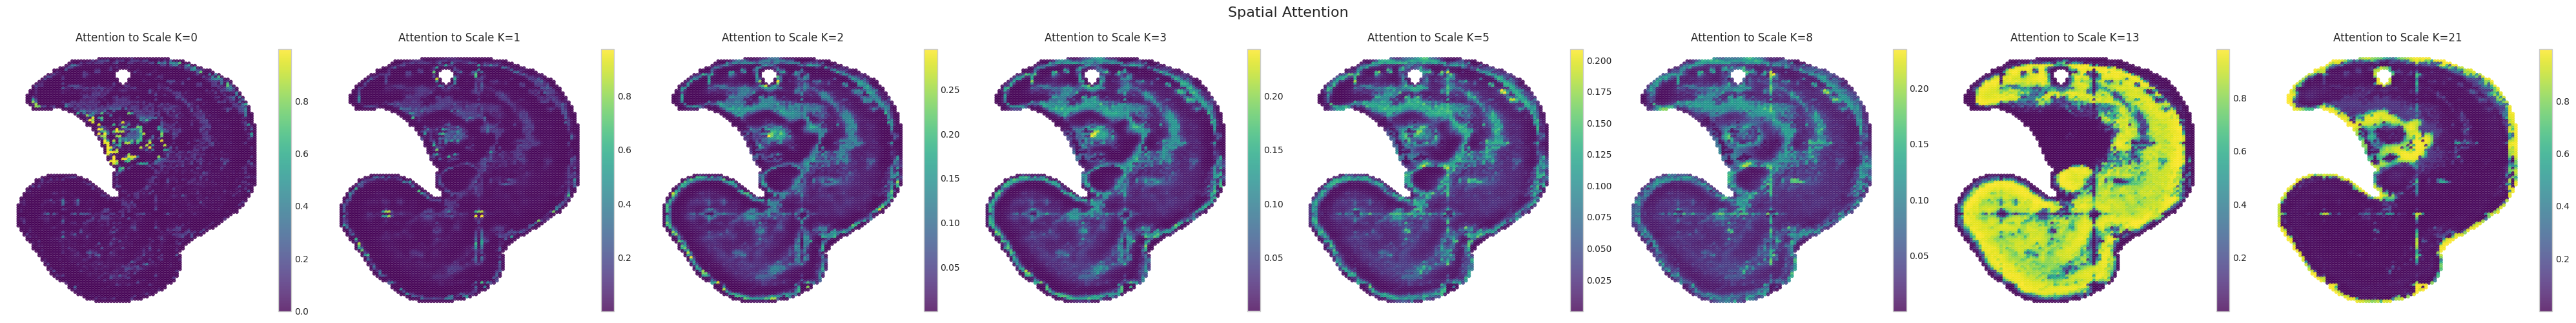

In [9]:
z_s, latent, attn = cps_model.interpret_attn_scores(pyg_data, verbose=True)
adata_hvg.obsm['z_s'] = z_s
adata_hvg.obsm['z_t'] = latent
adata_hvg.obsm['attns'] = attn
adata_hvg.obsm['attn'] = attn.reshape(adata_hvg.n_obs, 32)

In [10]:
args.clusters=14
adata_hvg = CPS.mclust(adata_hvg, args, key='z_s', pca_dim=32)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


[<Axes: title={'center': 'E9.5'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'annotation'}, xlabel='spatial1', ylabel='spatial2'>]

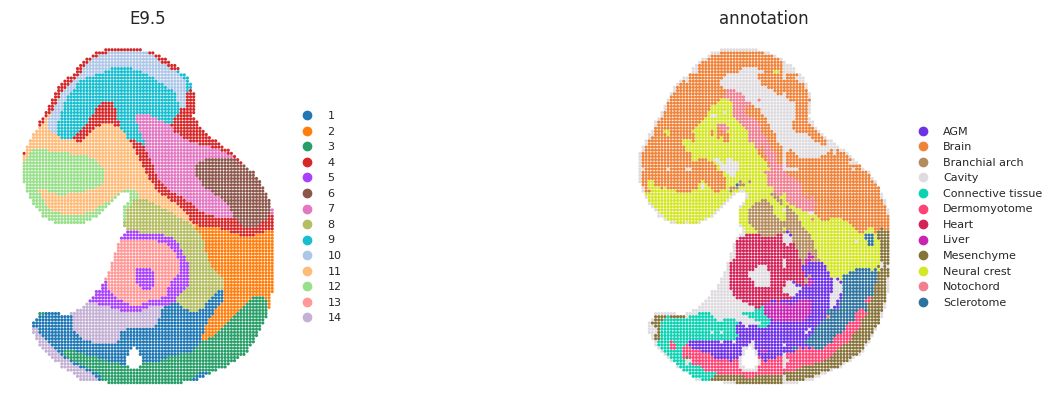

In [14]:
sc.pl.spatial(adata_hvg, img_key=None, color=['mclust','annotation'], 
              title=['E9.5'], size=1., legend_fontsize=8, 
              show=False, frameon=False, spot_size=1)